In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

1.8.1+cu101
True
1


In [3]:
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision.learner import cnn_config # notice this extra import 

from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json

from tqdm import tqdm #progress bars 
#import wandb #tracks and saves model parameters and performance

warnings.filterwarnings("ignore")

In [4]:
#mount my personal colabgoogle drive to this notebook. To use local files, you have to run colab from your local runtime
from google.colab import drive
drive.mount('/content/drive')

#create path object that is in your google drive 
path = Path('/content/drive/MyDrive/DSC 449 Project/AOI_5_Khartoum_Train') #DL/LiveEO/train')
Path.BASE_PATH = path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Checking what Google Colab is offering today :)
try:
  print(torch.cuda.get_device_properties(0))
except:
  print("No CUDA device available.")

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


### Data Augmentation (Will have to do augmentations manually for custom unet.)

In [ ]:
tfms = get_transforms()
img_url = '/content/drive/MyDrive/DSC 449 Project/AOI_5_Khartoum_Train/cut_MUL/MUL-PanSharpen_AOI_5_Khartoum_img1001_0_0.npy'
img = open_npy(img_url)
#img = open_image(img_url)
img.apply_tfms(tfms)

AttributeError: ignored

In [ ]:
img.apply_tfms(tfms)

In [ ]:
def open_npy(fn, ch_subset=None, cls=torch.Tensor):
    im = torch.from_numpy(np.load(str(fn)).astype(np.float16)).type(torch.float32)
    if ch_subset is not None: im = im[ch_subset]
    return cls(im)

In [ ]:
# Get transformations
tfms = get_transforms()# Create ImageDataBunch with transformations            
data_test = ImageDataBunch.from_folder(path,ds_tfms=tfms,size=224)# Show a train batch
data_test.show_batch()

In [ ]:
#These are data augmentations for training: 
tfms = [dihedral(),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2)#,
        #Normalize.from_stats(*imagenet_stats)
        ]

In [ ]:
#MAIN Training DataBlock:  
db = DataBlock(
      blocks =(TransformBlock(type_tfms=partial(MSTensorImage.create, chnls_first=True)),
               TransformBlock(type_tfms=[get_lbl_fn, partial(open_npy, cls=TensorMask)], item_tfms = AddMaskCodes(codes=CODES))),
               get_items=get_undersampled_tiles,                # Collect undersampled tiles
               splitter=RandomSplitter(valid_pct=0.15),        # Split into training and validation set
               batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
              )

In [ ]:
#display summary to make sure it is looking in the right directory and has the right number of images 
db.summary(source=path/"cut_MUL")

# Define the model 

### Import fastai's u-net for n-channel inputs using fastai v1

In [9]:
#create dataset for satellite imagery for fastai v1
class NBandDataset(Dataset):
    def __init__(self, img_src=None, rm_src=None, rm_empty = True, n_channels=3, pytorch=True):
        super().__init__() #

        self.rm_empty = rm_empty
        if rm_src:
            self.rm_list = list(open(rm_src,'r').read().splitlines()) #list of file names to not load
        else:
            self.rm_list = None 
        self.n_channels = n_channels
        self.base_path = img_src #path/cut_MUL in this case. This is the path to the numpy arrays of the images
        self.pytorch = pytorch
        if img_src:
            self.files = self.get_undersampled_tiles(img_src)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())
        return s
        
    def __getitem__(self, idx): #for indexing 
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        return x, y

    def get_undersampled_tiles(self, path:Path) -> list:
        dir_list = get_files(path, extensions='.npy') #"get_files" is a built in fastai function that recursively gets filenames in path
        if self.rm_empty:
            if self.rm_list:
                dir_list = [x for x in dir_list if str(x) not in self.rm_list] #only keep the directories of images we know have buildings in them 
            else: #do it the old fashioned way 
                keep = list(filter(self._has_buildings, dir_list)) #filter out tiles that don't have buildings
                self.rm_list = [x for x in dir_list if x not in keep]
                dir_list = keep.copy() 

        #make dictionaries out of img paths 
        output_files = [self.make_file_dict(file) for file in dir_list] 

        return output_files #list of file names 

    def make_file_dict(self, fn):
        #makes a dict for img and mask given an img filename
        d = {'img': fn,
             'gt': self._get_lbl_fn(fn)} #mask file name 
        return d 

    def _get_lbl_fn(self, img_fn: Path): 
        #input is an image path. Output is the path to the corresponding mask 
        lbl_path = img_fn.parent.parent/'npy_masks' #cut_masks
        lbl_name = str(img_fn.name).replace('MUL-PanSharpen', 'buildings') 
        return (lbl_path/lbl_name)

    #remove the paths to images that have no buildings. "Undersampling"
    def _has_buildings(self, img_fn: Path): 
        #input is an image path. Output is True/False for whether mask has a building
        lbl_path = img_fn.parent.parent/'npy_masks' #cut_masks
        lbl_name = str(img_fn.name).replace('MUL-PanSharpen', 'buildings') 
        mask = self.open_npy(lbl_path/lbl_name)
        count = torch.count_nonzero(mask)
        return count>0.0 

    def open_npy(self, fn, ch_subset=None, cls=torch.Tensor):
        im = torch.from_numpy(np.load(str(fn)).astype(np.float16)).type(torch.float32)
        if ch_subset is not None: im = im[ch_subset]
        return cls(im)

    def open_as_array(self, idx, ch_subset=None, invert=False):
        raw_img = self.open_npy(self.files[idx]['img'],ch_subset)
        #if invert:
        #    raw_img = raw_img.transpose((2,0,1)) #don't need this code, b/c I've already saved the numpy files as (8,255,255). This just makes sure the bands are axis=0. 
        # normalize between 0 and 1 
        #raw_img/raw_img.max() #don't need this code because I saved numpy files normalized already 
        return raw_img

    def open_mask(self, idx, add_dims=False,sub_dims=False):
        raw_mask = self.open_npy(self.files[idx]['gt'])
        raw_mask = np.where(raw_mask==255, 1, 0) #assuming binary mask! 
        if sub_dims:
            x = raw_mask.shape[2]
            raw_mask = raw_mask.reshape((x,x))
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def open_as_pil(self, idx, ch_subset=[4,2,1]): #8 channels are: Coastal Blue, Blue, Green, Yellow, Red, Red Edge, Near Infrared 1 (NIR1), and Near Infrared 2 (NIR2), so this is RGB
        arr = 255*self.open_as_array(idx, ch_subset)
        arr = arr.numpy().astype(np.uint8) #convert tensor to numpy array for display 
        arr = arr.transpose((1,2,0)) #(255,255,3) for display
        return arr #Image.fromarray(arr, 'RGB')

    def save(self, fn): 
        #save the list of image paths of images we did not save 
        if not self.rm_list:
            print('Did not remove images in current dataset. Nothing to save.')
            return 
        
        with open(fn,'w') as out_file: #"w" will delete old version of the file and overwrite without appending 
            for directory in self.rm_list:
                out_file.write(str(directory)+"\n")



### first time creation of dataset

In [ ]:
data = NBandDataset(path/'npy_MUL', rm_empty=True, n_channels=8) 
print(len(data))

rm_file = '/content/drive/MyDrive/DSC 449 Project/AOI_5_Khartoum_Train/npy_no_buildings_list.txt'
data.save(rm_file)

923


### ... or, load dataset from previous run 

In [10]:
data = NBandDataset(path/'npy_MUL', rm_src=path/'npy_no_buildings_list.txt', n_channels=8) 
len(data)

923

In [11]:
## Check the dimensions of the arrays 
# should be: (torch.Size([8, 255, 255]), torch.Size([1, 255, 255]))
#For uncut images, need them to be 640x640 instead of 650x650. 
x , y = data[100]
x.shape, y.shape

RuntimeError: ignored

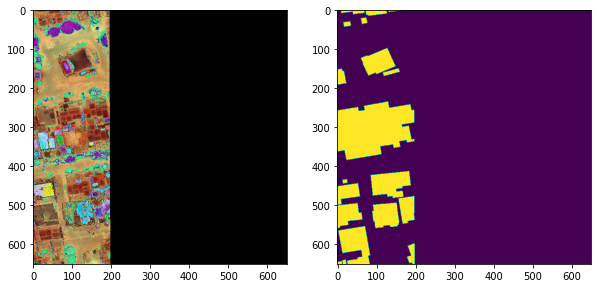

In [10]:
#show a random tile in your dataset to make sure it's built correctly
index = 5
fig, ax = plt.subplots(1,2,figsize=(10,9))
ax[0].imshow(data.open_as_pil(index))
ax[1].imshow(data.open_mask(index,sub_dims=True))

In [ ]:
#close enough... To get a good image, look at the notebook that does the cutting. 

In [8]:
#create training and testing data loaders 
valid_prop = 0.2 
train_count = round(len(data)*(1-valid_prop))
valid_count = round(len(data)*valid_prop)
np.random.seed(42)
train_ds, valid_ds = torch.utils.data.random_split(data, (train_count,valid_count)) #to do: filter "no_buildings" after this split. 

#get a sample
sample_x, sample_y = next(iter(train_ds))
sample_x.shape, sample_y.shape #from training set 

(torch.Size([8, 650, 650]), torch.Size([1, 650, 650]))

In [9]:
len(train_ds),len(valid_ds), sum([len(train_ds),len(valid_ds)])

(738, 185, 923)

In [10]:
#make data loaders out of datasets 
batch_size = 8
np.random.seed(42)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl= DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

#get another sample to check dimensions 
sample_x, sample_y = next(iter(train_dl))
sample_x.shape, sample_y.shape #from training set 

(torch.Size([8, 8, 650, 650]), torch.Size([8, 1, 650, 650]))

# Define the model 

In [18]:
from torch import nn
#source: https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
class UNET(nn.Module): #for torch libraries, you have to put the nn.Module in the parenthesis
    def __init__(self, in_channels, out_channels):
        super().__init__()

        #model architecture: 
        self.conv1 = self.contract_block(in_channels, 32, 7, 3) #need a large padding for such a large kernel. 
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1) #the time 2 comes from the face that we are concatonating the output from previous layer and residual layer acrros the network. 
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1, final_output=True)
        #^ This is a *tiny* U-net. OG model has 5 down layers: 64->128->256->512->1024 then 4 layers back up to 1... And using the resnet34 increases the layers even more... 

    def __call__(self, x): #This is a necessary method for a torch model to have apparently. 
        #runs the model forward 

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        # upsampling part  
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1)) #concat residuals with upsampling output 
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding, final_output=False):
        if final_output:
            output_padding=0
        else:
            output_padding=1

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=output_padding) 
                            )
        return expand

In [ ]:
#testing one pass output  to make sure the dimensions are all correct within the model 
learner = UNET(8,1) #8 input channels and 1 output channel for our custom U-net architecture

#test the u-net on one batch
xb, yb = next(iter(train_dl))
pred= learner(xb)
pred.shape #the output shape should be 4 dimensions that match the mask shape

In [13]:
#Just to demonstrate, the u-net is reducing/expanding the spatial dimensions by 1/4 in each block 
testconv = learner.contract_block(8,32,7,3)
l1_out = testconv(xb) #layer one output 
l1_out.shape

torch.Size([8, 32, 325, 325])

In [ ]:
#verify loss function is working
yb.unique()

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() #for n classes = 1 
loss=loss_fn(pred,yb.float()) #both pred and target have to be floats. not all torch modules can handle Long datatypes. 
loss

In [ ]:
#it works! The model is built. Now we can train it. 

# Train the model 

In [ ]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time() #start the clock 
    model.cuda() #tell the momdel to run on GPU 

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs.float(), y.float()) #your y should always be a float 

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs.float(), y.float()) #your y should always be a float 

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Dice: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Dice: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

In [ ]:
def acc_metric(predb, yb):
    #Dice score aka F1-score on a pixel basis (SpaceNet challenge was on a building basis...)
    #F1 = 2TP / (2TP+FP+FN) where FP+FN => sum(yhat!=y)
    #Dice is 0-1 
    yhat = torch.round(torch.clip(predb,0,1)) #make your predictions binary 
    TP = ((yhat==1) & (yb.cuda()==1)).sum()
    return TP*2/(TP*2 + (yhat != yb.cuda()).sum()) 
    #return (predb.argmax(dim=1) == yb.cuda()).float().mean() #counting pixels correctly classified 

In [ ]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = learner(xb.cuda())  #This is now the prediction of the trained model 

predb.shape

In [ ]:
((torch.round(torch.clip(predb,0,1))==1) & (yb.cuda()==1)).sum()

tensor(865153, device='cuda:0')

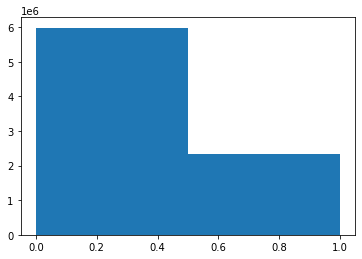

In [ ]:
plt.hist(torch.round(torch.clip(predb,0,1)).cpu().flatten(), bins = 2)
plt.show()

In [ ]:
np.random.seed(42)
learner = UNET(8,1)
loss_fn = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #Cross Entropy for class >2 and BCEWithLogitsLoss for class == 1. IDK why, but CE gives an error if class == 1. 
opt = torch.optim.Adam(learner.parameters(), lr=0.001)

train_loss, valid_loss = train(learner, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=4) #about a minute per 10 steps. each step has a batch of 12 imgs. 6509/12 = 542 ~ 1 hour per epoch 

Epoch 0/3
----------
Current step: 10  Loss: 0.6694015264511108  Dice: 0.009780067019164562  AllocMem (Mb): 96.31689453125
Current step: 20  Loss: 0.657333493232727  Dice: 0.02006417140364647  AllocMem (Mb): 96.31689453125
Current step: 30  Loss: 0.655898928642273  Dice: 0.00676645478233695  AllocMem (Mb): 96.31689453125
Current step: 40  Loss: 0.648984432220459  Dice: 0.019256459549069405  AllocMem (Mb): 96.31689453125
Current step: 50  Loss: 0.6523330211639404  Dice: 0.020234307274222374  AllocMem (Mb): 96.31689453125
Current step: 60  Loss: 0.6515801548957825  Dice: 0.04835246875882149  AllocMem (Mb): 96.31689453125
Current step: 70  Loss: 0.6469733119010925  Dice: 0.04621117189526558  AllocMem (Mb): 96.31689453125
Current step: 80  Loss: 0.6386152505874634  Dice: 0.06717564165592194  AllocMem (Mb): 96.31689453125
Current step: 90  Loss: 0.6344737410545349  Dice: 0.10421503335237503  AllocMem (Mb): 96.31689453125
Current step: 100  Loss: 0.6348099112510681  Dice: 0.13474372029304504

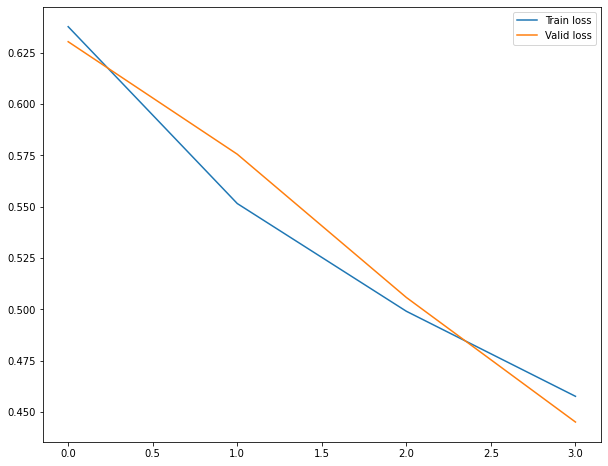

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [ ]:
xb, yb = next(iter(valid_dl))

with torch.no_grad():
    predb = learner(xb.cuda())  #This is now the prediction of the trained model 

predb.shape

torch.Size([32, 1, 255, 255])

In [ ]:
def batch_to_img(xb, idx):
    img = np.sum(np.array(xb[idx,:]),axis=0) #sum over all bands 
    img /= img.max() #normalize to 0-255
    return (img*255).astype(np.uint8)

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
batch_to_img(xb,0).shape

(255, 255)

## Display images in the first batch 

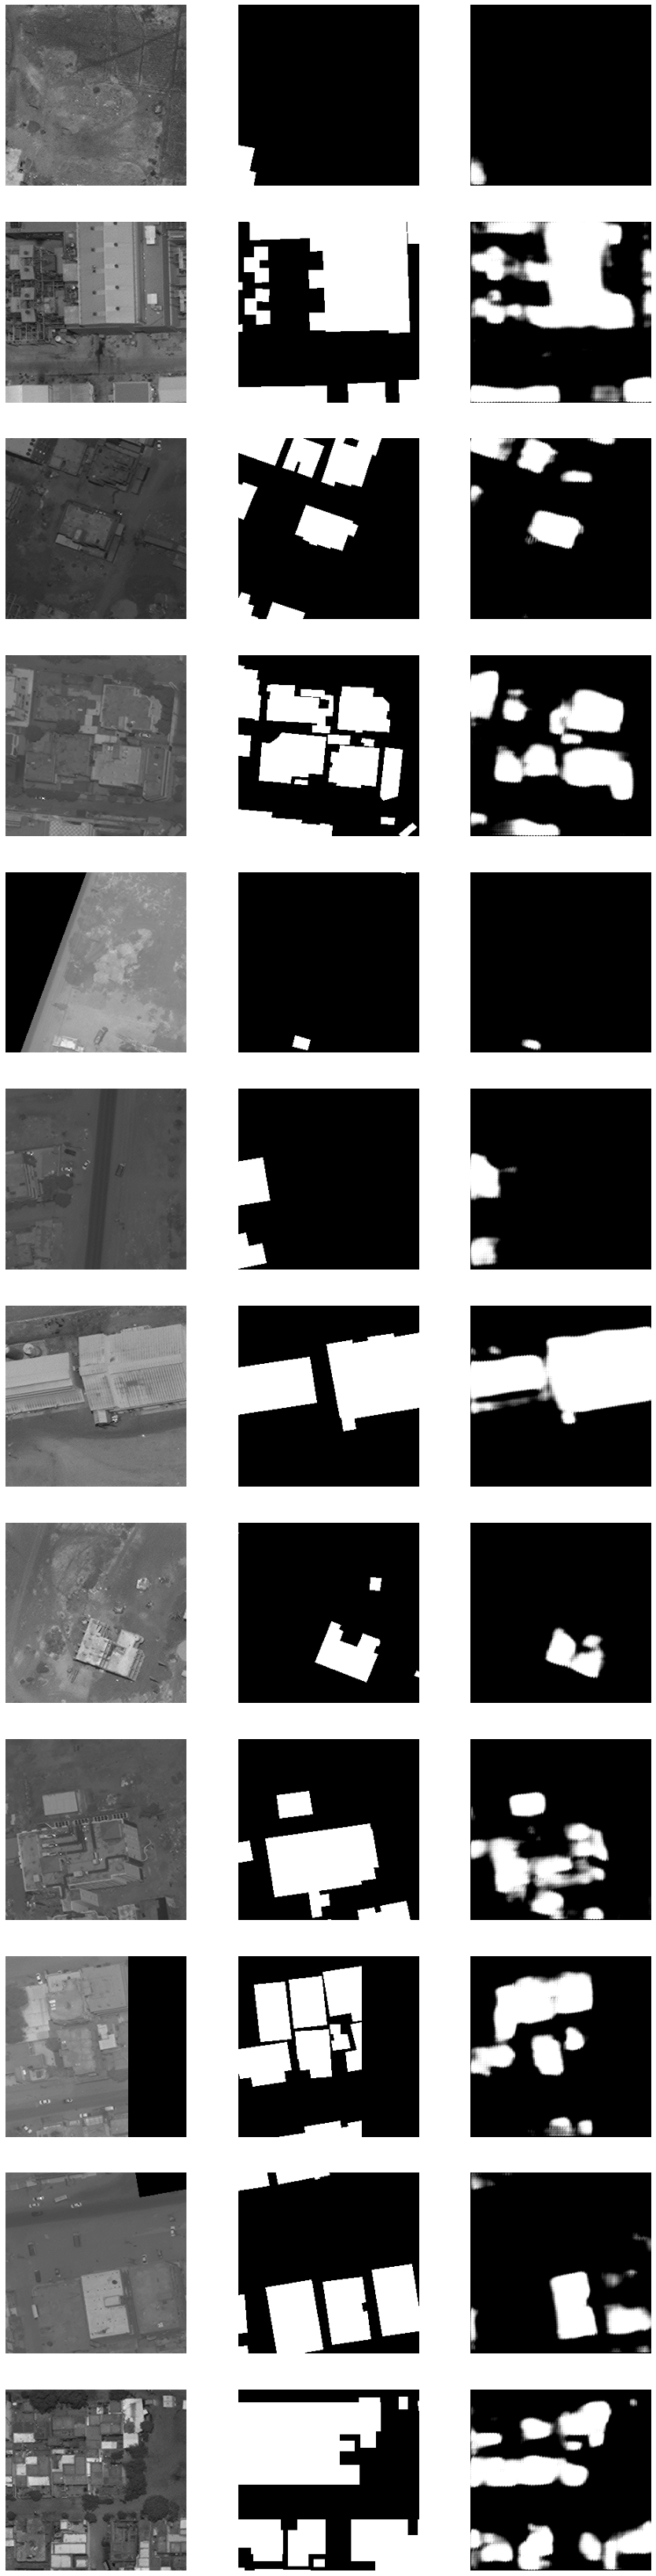

In [ ]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].axis("off")
    ax[i,0].imshow(batch_to_img(xb,i), cmap="gray")
    ax[i,1].axis("off")
    ax[i,1].imshow(yb[i].squeeze(),cmap="gray")
    ax[i,2].axis("off")
    ax[i,2].imshow((predb.squeeze().cpu().numpy()[i].clip(0,1)*255).astype(np.uint8),cmap="gray")

TO DO: 
- What is final output of our project!? How to post-process this result to compare with the bounding box method? 
- more tuning and training with different hyper parameters 
- more validation. Can you build a regression model to population from these footprint predicitons?
- Can you train on full 650x650 images? 
- Can you compare performance with non-pansharpened images? 
- How can you compare this model's performance with the other's from SpaceNet? 
- If you have time, train with alternative masks. 